In [ ]:
%%capture
!pip install -Uqq fastai
!apt-get install tree

Introduction and Setup

In the previous module, we created filters and applied them over images to create feature maps. We also saw that freshly initialized CNNs generate similar feature maps since the weights are initialized at random. In this module, we're going to create our first deep colvolutional neural network. Instead of using random filters, we're going to learn useful filters during training that help us classify digits. We'll also inspect the feature maps generated by those filters to gain some intuition about what is learned by that filter.

We've attempted this task with a fully-connected neural network and achieved a validation accuracy of about 0.965 after 10 epochs. In this module, we'll reach that level of accuracy after only 1 epoch; within 2, our accuracy should be over 0.99.

In this module, we'll first try and gain some intuition as to why CNNs work. Then, we'll build and train a CNN and inspect some features.

Setup

In [ ]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from fastai.vision.all import *
from fastai import *
from torchvision import transforms
import pandas as pd

Loading the Data

For this lesson, we'll be using fastai. One great part of the library is its datasets module. It has a number of great datasets to work with, and we'll continue to use them throughout the course. Additionally, when you use FastAI, their datasets are generally easily converted into dataloaders.

In [ ]:
path = untar_data(URLs.MNIST)

Let's check out the directory structure of the data. It looks like there is a training and testing folder, each filled with images of digits.

In [ ]:
print('First 2 levels of the data directory... \n')
!tree -L 2 {str(path)}
# print('\nLooking at the first 10 files in the training/0 directory...\n')
!ls {str(path/'training/0')} | head -n 10

First 2 levels of the data directory... 

/root/.fastai/data/mnist_png
├── testing
│   ├── 0
│   ├── 1
│   ├── 2
│   ├── 3
│   ├── 4
│   ├── 5
│   ├── 6
│   ├── 7
│   ├── 8
│   └── 9
└── training
    ├── 0
    ├── 1
    ├── 2
    ├── 3
    ├── 4
    ├── 5
    ├── 6
    ├── 7
    ├── 8
    └── 9

22 directories, 0 files
10005.png
1000.png
10010.png
10022.png
10025.png
10026.png
10045.png
10069.png
10071.png
10080.png


The data is organized in a way that's compatible with FastAI's ImageDataLoaders.from_folder. This creates our training and validation dataloaders in the dls object.

In [ ]:
dls = ImageDataLoaders.from_folder(path, 'training', 'testing')

Below, we observe 1 batch of data.

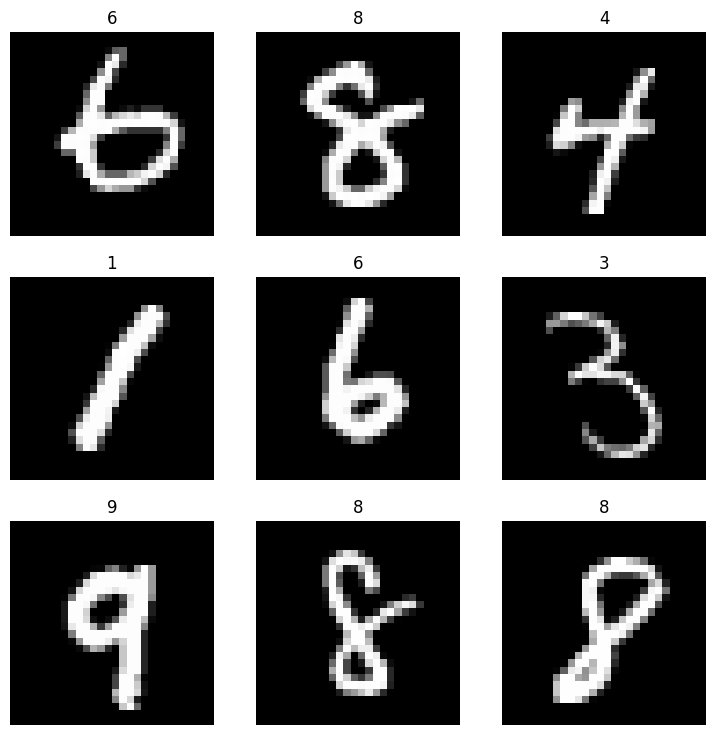

In [ ]:
dls.show_batch()

Let's examine this data. To determine whether we need to scale the data, let's look at the min and max of a single batch of images. Let's also look at the shape of those images.

After some quick observation, it looks like we're working with 3-channel images that are pre-scaled. It also seems like the channels have already been moved to the first dimension. We're ready to begin creating our model!

In [ ]:
x_b, y_b = dls.one_batch()

x_b.max(), x_b.min(), x_b.shape, y_b

(TensorImage(1., device='cuda:0'),
 TensorImage(0., device='cuda:0'),
 torch.Size([64, 3, 28, 28]),
 TensorCategory([8, 5, 0, 4, 7, 8, 8, 2, 9, 4, 6, 0, 5, 1, 8, 3, 9, 7, 5, 4, 4,
                 3, 8, 2, 6, 4, 9, 2, 8, 4, 0, 3, 7, 1, 7, 3, 7, 3, 0, 1, 8, 3,
                 3, 2, 1, 5, 9, 6, 7, 2, 4, 1, 4, 9, 5, 8, 5, 1, 0, 7, 2, 6, 6,
                 2], device='cuda:0'))

Building our Model

In this lesson, we'll build our first convolutional neural network.

When building neural networks, you will often repeat the same block of code many times. In this case, we're using a repeating pattern of convolution, activation function, batch normalization, and dropout. Instead of writing that many times, let's just write one function that takes care of it for us.

NOTE: In previous lessons working with nn.Linear layers, we used nn.BatchNorm1d. In this case, we're using nn.BatchNorm2d. Instead of normalizing on a per-feature basis for a vector, nn.BatchNorm2d normalizes on a per-channel basis. For example, if there is a 3-channel input, it will track 3 \(\beta\) and 3 \(\gamma\) parameters, and scale the entire channel based on one set of parameters.

In [ ]:
def conv_block(in_channels, out_channels, kernel_size=3, padding=1, stride=1, dropout=0.2, *args, **kwargs):
    """
    Returns a sequential module of a conv block that we want to repeat.
    """
    return nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, **kwargs),
        nn.PReLU(),
        nn.BatchNorm2d(out_channels),
        nn.Dropout2d(dropout)
    )

Now let's create our model. The one we have here has 5 convolutional layers, annotated with the shape of the activation outputs. Notice that we start with a 3x28x28 image as an input. This is generally referred to as the lower layers in the network. As we move towards the top, we increase the number of channels from 3, to 32, to 64, to 128. Each of these channels can be thought of as 1 "feature," and the activations of the that layer can be thought of as how that feature is expressed in different areas of the image.

At the same time, we are using striding to reduce spatial information. Eventually, we end up with a flattened vector of 128 for each image that has no spatial information whatsoever. This vector is then fed into a linear classifier that learns to separate digits in that 128-dimensional space. See the comments in the network to see the shapes of the feature maps at each layer.

We'll see this as a theme in image classification and encoding - we begin to diminish information about "where" by using pooling or strides. Instead, we begin to information about "what", expressed by an increasing amount of filters. We end up with reduced spatial resolution, but many features about what is in the image.

In [ ]:
# Build our model
model = nn.Sequential(
    conv_block(3, 32), # 3x28x28 --> 32x28x28
    conv_block(32, 64), # 32x28x28 --> 64x28x28
    conv_block(64, 64, stride=2), # 64x28x28 --> 64x14x14
    conv_block(64, 128), # 64x14x14 --> 128x14x14
    conv_block(128, 128, stride=2), # 128x14x14 --> 128x7x7
    nn.AdaptiveMaxPool2d(1), # 128x7x7 --> 128
    nn.Flatten(), # 1x1x128 --> 128
    nn.Linear(128, 10) # 128 features --> 10 outputs
)

# Display our model
model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout2d(p=0.2, inplace=False)
  )
  (1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout2d(p=0.2, inplace=False)
  )
  (2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout2d(p=0.2, inplace=False)
  )
  (3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_

Training

In this lesson, we'll use the model we created in the previous lesson and train it to classify digits. Currently, the parameters in each filter are random - by the end of this lesson, the parameters will extract features that help classify digits.

First, let's define a few things we need for training. In the cell below, we define a few things:

Our callbacks - in this case, we'll just use early stopping. If the validation loss does not decrease for a number of epochs defined by the hyperparameter patience, training will stop.
Metrics - we'll use two metrics here, accuracy and error rate. Error rate is 1 - accuracy, but since accuracy gets very high after just a few epochs it can be useful to examine a smaller number. Feel free to explore the metrics module and add any additional metrics.
Our loss function. We'll use FastAI's CrossEntropyLossFlat. It's the same as nn.CrossEntropyLoss, but flattens the outpts and target.

In [ ]:
cbs = [
    EarlyStoppingCallback()
]

mets = [
    metrics.accuracy,
    metrics.error_rate
]

loss = CrossEntropyLossFlat()

In the cell below, we instantiate our learner. This object bundles our training and validation data, the model, our loss, metrics, and callbacks. This object will manage the entire training loop for us. Once we've created it, the hard work is done!

In [ ]:
learn = Learner(dls, model, loss, metrics=mets, cbs=cbs)

Finally, we can train our model for a few epochs. Recall that in previous lessons using linear classifiers of vectorized images, we achieved about a 96% accuracy after about 10 epochs. In this training run, we'll achieve around 99% in just 2 epochs!

In [ ]:
LR = 1e-3
learn.fit_one_cycle(2, LR)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.142606,0.048829,0.983600,0.016400,01:20
1,0.064448,0.025999,0.992000,0.008000,01:08


Aside: What is fit_one_cycle?

We've just seen something new here. Instead of .fit like we're used to, the Learner object has a .fit_one_cycle method. What is this doing?

The idea behind a one-cycle policy is that we can use a high learning with low momentum rate for a number of steps to push our parameters out of local minima in the loss landscape. Then, once the learning rate begins to decrease, the parameters can settle into a new minimum that (hopefully) could be better.

In fastai, every time you call fit_one_cycle, the cycle is repeated. For examle, we called fit_one_cycle(3), telling the software to run one cycle over 3 epochs. If we had called fit_one_cycle(5), one cycle would have run over 5 epochs instead of 3.

learn.recorder.plot_sched() shows you the learning rate and momentum over the cycle you just ran (shown below). On the x-axis, you have the step (batch) number, and on the y-axis there are different hyperparameter schedules - in this case, learning rate and momentum.

For additional reading on the one-cycle policy, you can check out the original paper, this post on Kaggle, and the fastai documentation. Other DL frameworks also have their own versions of one-cycle schedulers. fastai uses a special type of one-cycle policy that's a combination of two cosine functions called cosine annealing.

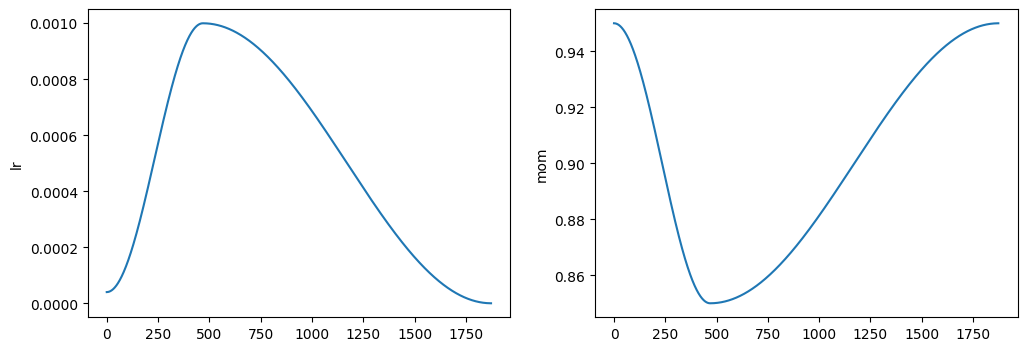

In [ ]:
learn.recorder.plot_sched()

What is our network learning?

In the last lesson, we spent a lot of time looking at activation maps. In this next section, we're going to take a peek inside our network to see what sorts of features our models are learning at different layers.

We'll do this with a concept called hooks. Hooks allow us to inspect the inputs and outputs to a layer in either the forward and backward direction. fastai also provides some really convenient functions.

In this section, we'll use the hook_output function to capture the activations of one convolutional layer of our network.

The function below passes a batch of images through the model, and retrieves the feature maps for a given layer. Then, it visualizes a random sample of those feature maps along with the original image. We'll use this function to examine the feature maps at different layers.

In [ ]:
def visualize_filters(layer, batch, batch_idx):
    with hook_output(model[layer][0]) as hook:
        # Pass one batch through the model, outputs will be stored in hook.stored
        with torch.no_grad():
            _ = learn.model(batch)
            # Store the outputs
            outputs = hook.stored

    # Pick an index in the batch
    n_filters = outputs.shape[1]
    output_size = outputs.shape[2]
    # Pick 9 random filters to visualize
    sampled_filters = np.random.choice(range(n_filters), 9)

    # Show the outputs for our 9 randomly sampled filters
    fig = plt.figure(figsize=(10, 10))
    for i, fidx in enumerate(sampled_filters):
        ax = fig.add_subplot(3, 3, 1+i)
        if i == 0: # Plot the original image in the upper left
            show_image(batch[batch_idx], title='Original', ax=ax)
            # plt.close()
        else: # Plot activation maps of the randomly sampled filters
            ax.matshow(
                outputs[batch_idx, fidx].squeeze().cpu().numpy(),
                cmap='Greys_r'
            )
        # Get rid of ticks & labels
        ax.set_xticklabels([])
        ax.set_xticks([])
        ax.set_yticklabels([])
        ax.set_yticks([])
    fig.tight_layout()
    plt.close()
    return fig

First, let's examine the feature maps of the first layer. We can see that the feature maps are the same size as the original image, and might deterc relatively simple features.

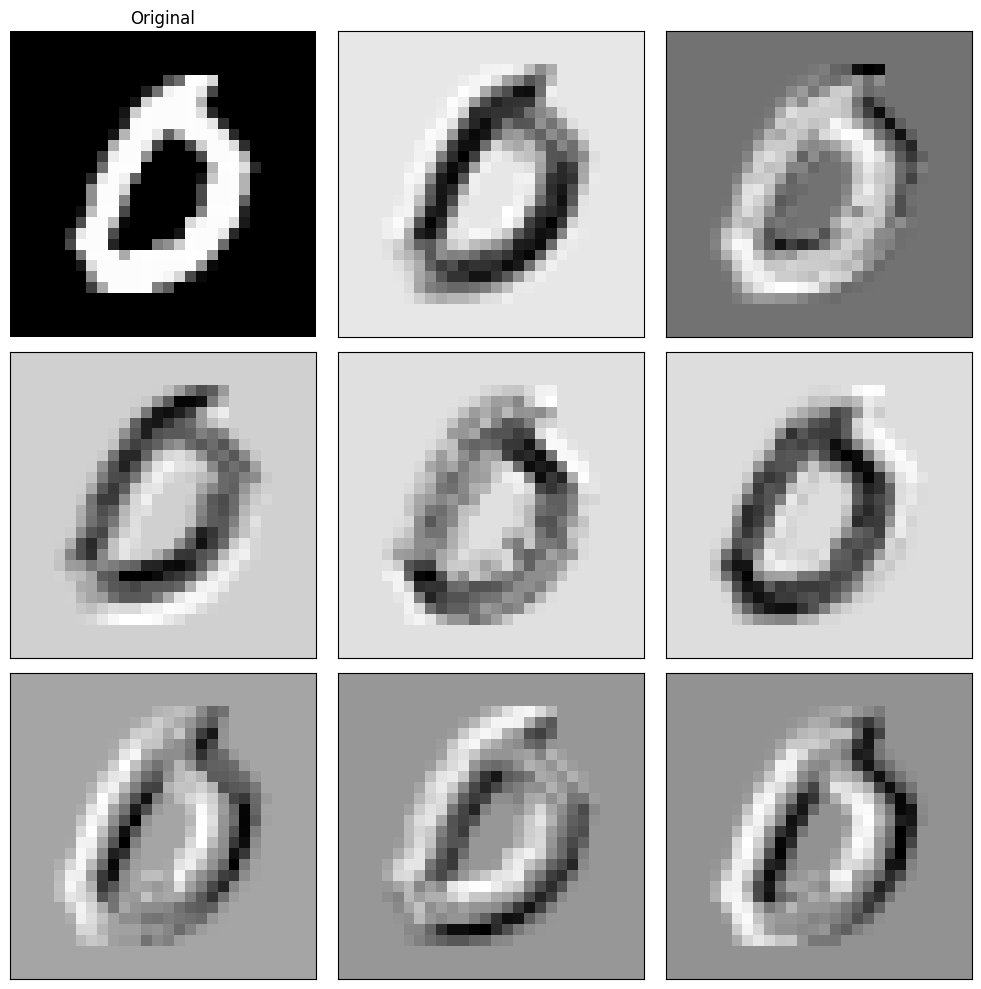

In [ ]:
visualize_filters(0, x_b, 2)

Let's go a few layers deeper. At the 3rd conv layer, we reduced the spatial frequency using striding. You may be able to venture a guess as to the digit from the feature maps, but they are a bit more abstract than the previous layer observed.

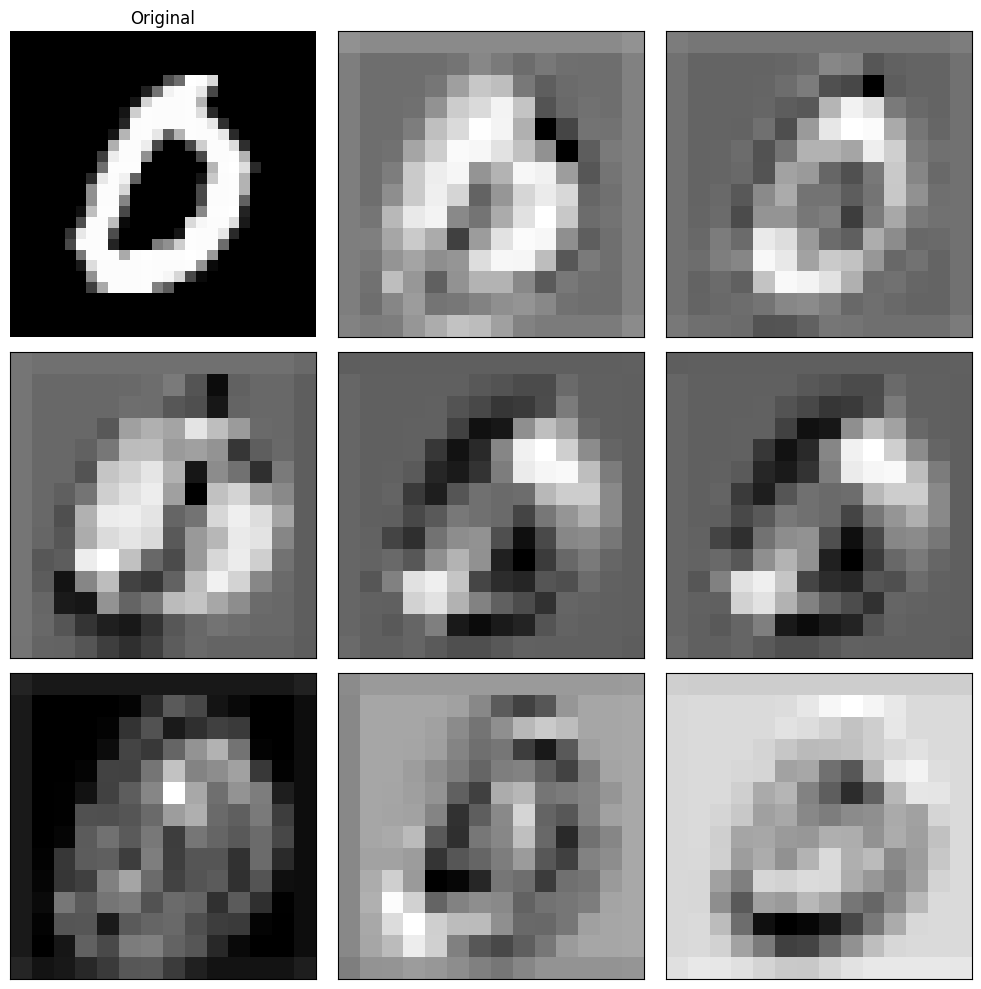

In [ ]:
visualize_filters(2, x_b, 2)

Finally, let's look at the outputs of our final convolutional layer. We can see that the dimensions are reduced even further to 7x7, and it's pretty impossible to tell what the original image was from the activation maps. This is because the features extracted here are much more abstract, and represent high-level features of images. Although they are not very interpretable to us as humans, these types of features are very useful for our final classification layer.

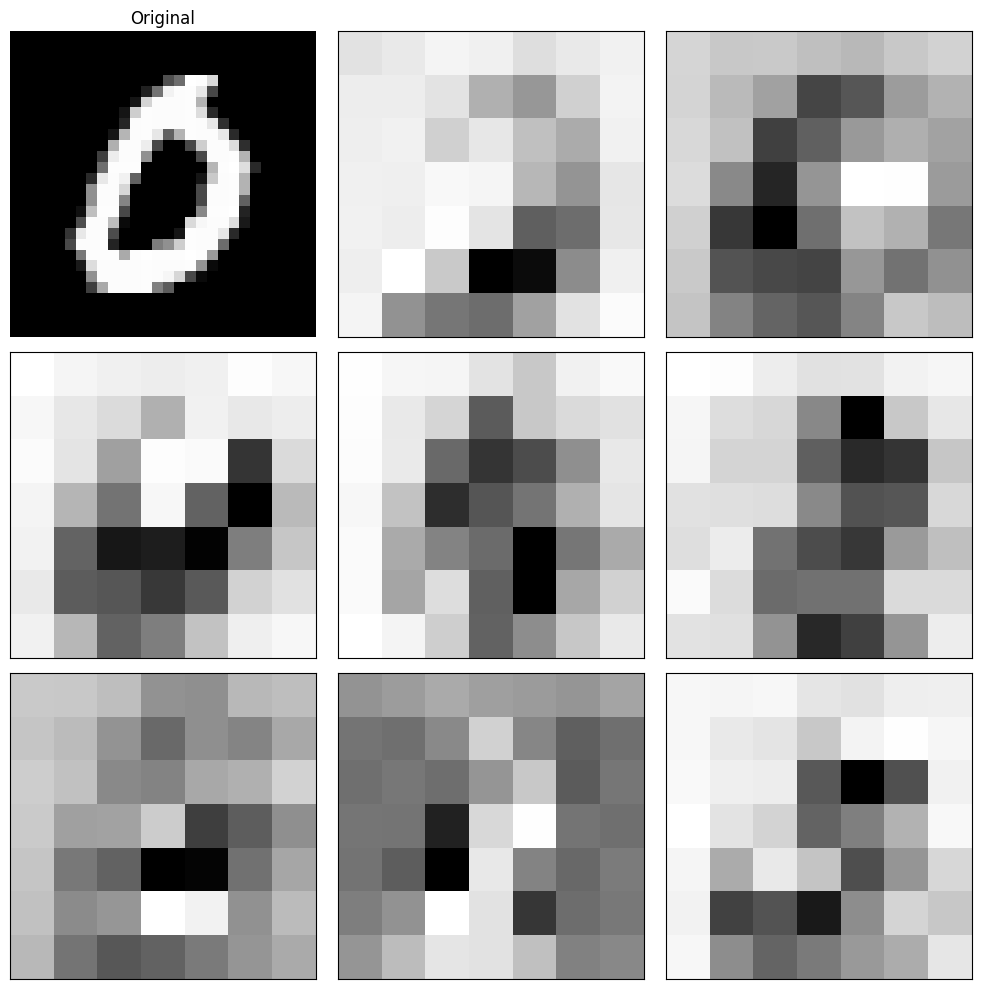

In [ ]:
visualize_filters(4, x_b, 2)